## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 17 12:01:13 2017
@author: abhijeet
"""

import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


## Functions

In [0]:
# load models from file
def load_all_models():
    all_models = []
    models_list = [os.path.join("/content/drive/My Drive/Colab Notebooks/mgu/ens_models", elem) for elem in os.listdir("/content/drive/My Drive/Colab Notebooks/mgu/ens_models")]
    for mod in models_list:
        # load model from file
        model = keras.models.load_model(mod)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % model)
    return all_models

def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = np.dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

# fit a model based on the outputs from the ensemble members
def fit_stacked_model_log_reg(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model

def transform_seqential_to_functional(members):
    from tensorflow.keras import layers, models

    members_new = []
    for member in members:
        if type(member) is tf.python.keras.engine.sequential.Sequential:
            member.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
            input_layer = layers.Input(shape=x_train.shape[1:])
            prev_layer = input_layer
            for layer in member.layers:
                layer._inbound_nodes = []
                prev_layer = layer(prev_layer)

            members_new.append(models.Model([input_layer], [prev_layer]))
        else:
            members_new.append(member)
    return members_new

def fit_stacked_model(model, inputX, inputy, epochs):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# encode output data
	# fit model
	model.fit(X, inputy, epochs=epochs, verbose=1)
 
 # define stacked model from multiple member input models
def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = keras.layers.concatenate(ensemble_outputs)
	hidden = keras.layers.Dense(100, activation='relu')(merge)
	output = keras.layers.Dense(10, activation='softmax')(hidden)
	model = keras.models.Model(inputs=ensemble_visible, outputs=output)
 	# compile
	model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
	return model

def generate_data_generator_for_two_images(X1, Y, batch_size, n_inputs):
    datagen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        )
    datagen.fit(X1)
    genX1 = datagen.flow(X1,Y, seed=7)
    while True:
            X1i = genX1.next()
            yield [X1i[0] for _ in range(n_inputs)], X1i[1]

## Data load and preproccess

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

num_classes = 10
y_train = keras.utils.to_categorical(y_train,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)


170500096/170498071 [==============================] - 2s 0us/step


## Model architecture 

In [5]:
# load all models
members = load_all_models()
print('Loaded %d models' % len(members))

>loaded <tensorflow.python.keras.engine.training.Model object at 0x7f3ebc1ecdd8>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x7f3ea6fe6630>
>loaded <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f3ebc0fb4e0>
>loaded <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f3ea6d87438>
>loaded <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f3ea6bff710>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x7f3f1bd62908>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x7f3ea6918d30>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x7f3ea678deb8>
>loaded <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f3ea698c4e0>
Loaded 9 models


### Change Sequential to functional models

In [6]:
members = transform_seqential_to_functional(members)
for i in range(len(members)):
    print(type(members[i]))

<class 'tensorflow.python.keras.engine.training.Model'>
<class 'tensorflow.python.keras.engine.training.Model'>
<class 'tensorflow.python.keras.engine.training.Model'>
<class 'tensorflow.python.keras.engine.training.Model'>
<class 'tensorflow.python.keras.engine.training.Model'>
<class 'tensorflow.python.keras.engine.training.Model'>
<class 'tensorflow.python.keras.engine.training.Model'>
<class 'tensorflow.python.keras.engine.training.Model'>
<class 'tensorflow.python.keras.engine.training.Model'>


## Logistic regrression stacked model

In [7]:
model = fit_stacked_model_log_reg(members, x_test, np.argmax(y_test, axis=1))
# make a prediction with the stacked model
# evaluate model on test set
yhat = stacked_prediction(members, model, x_test)
acc = accuracy_score(np.argmax(y_test, axis=1), yhat)
print('Stacked Test Accuracy: %.3f' % acc)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Stacked Test Accuracy: 0.930


## Meta model 

In [0]:
model = define_stacked_model(members)

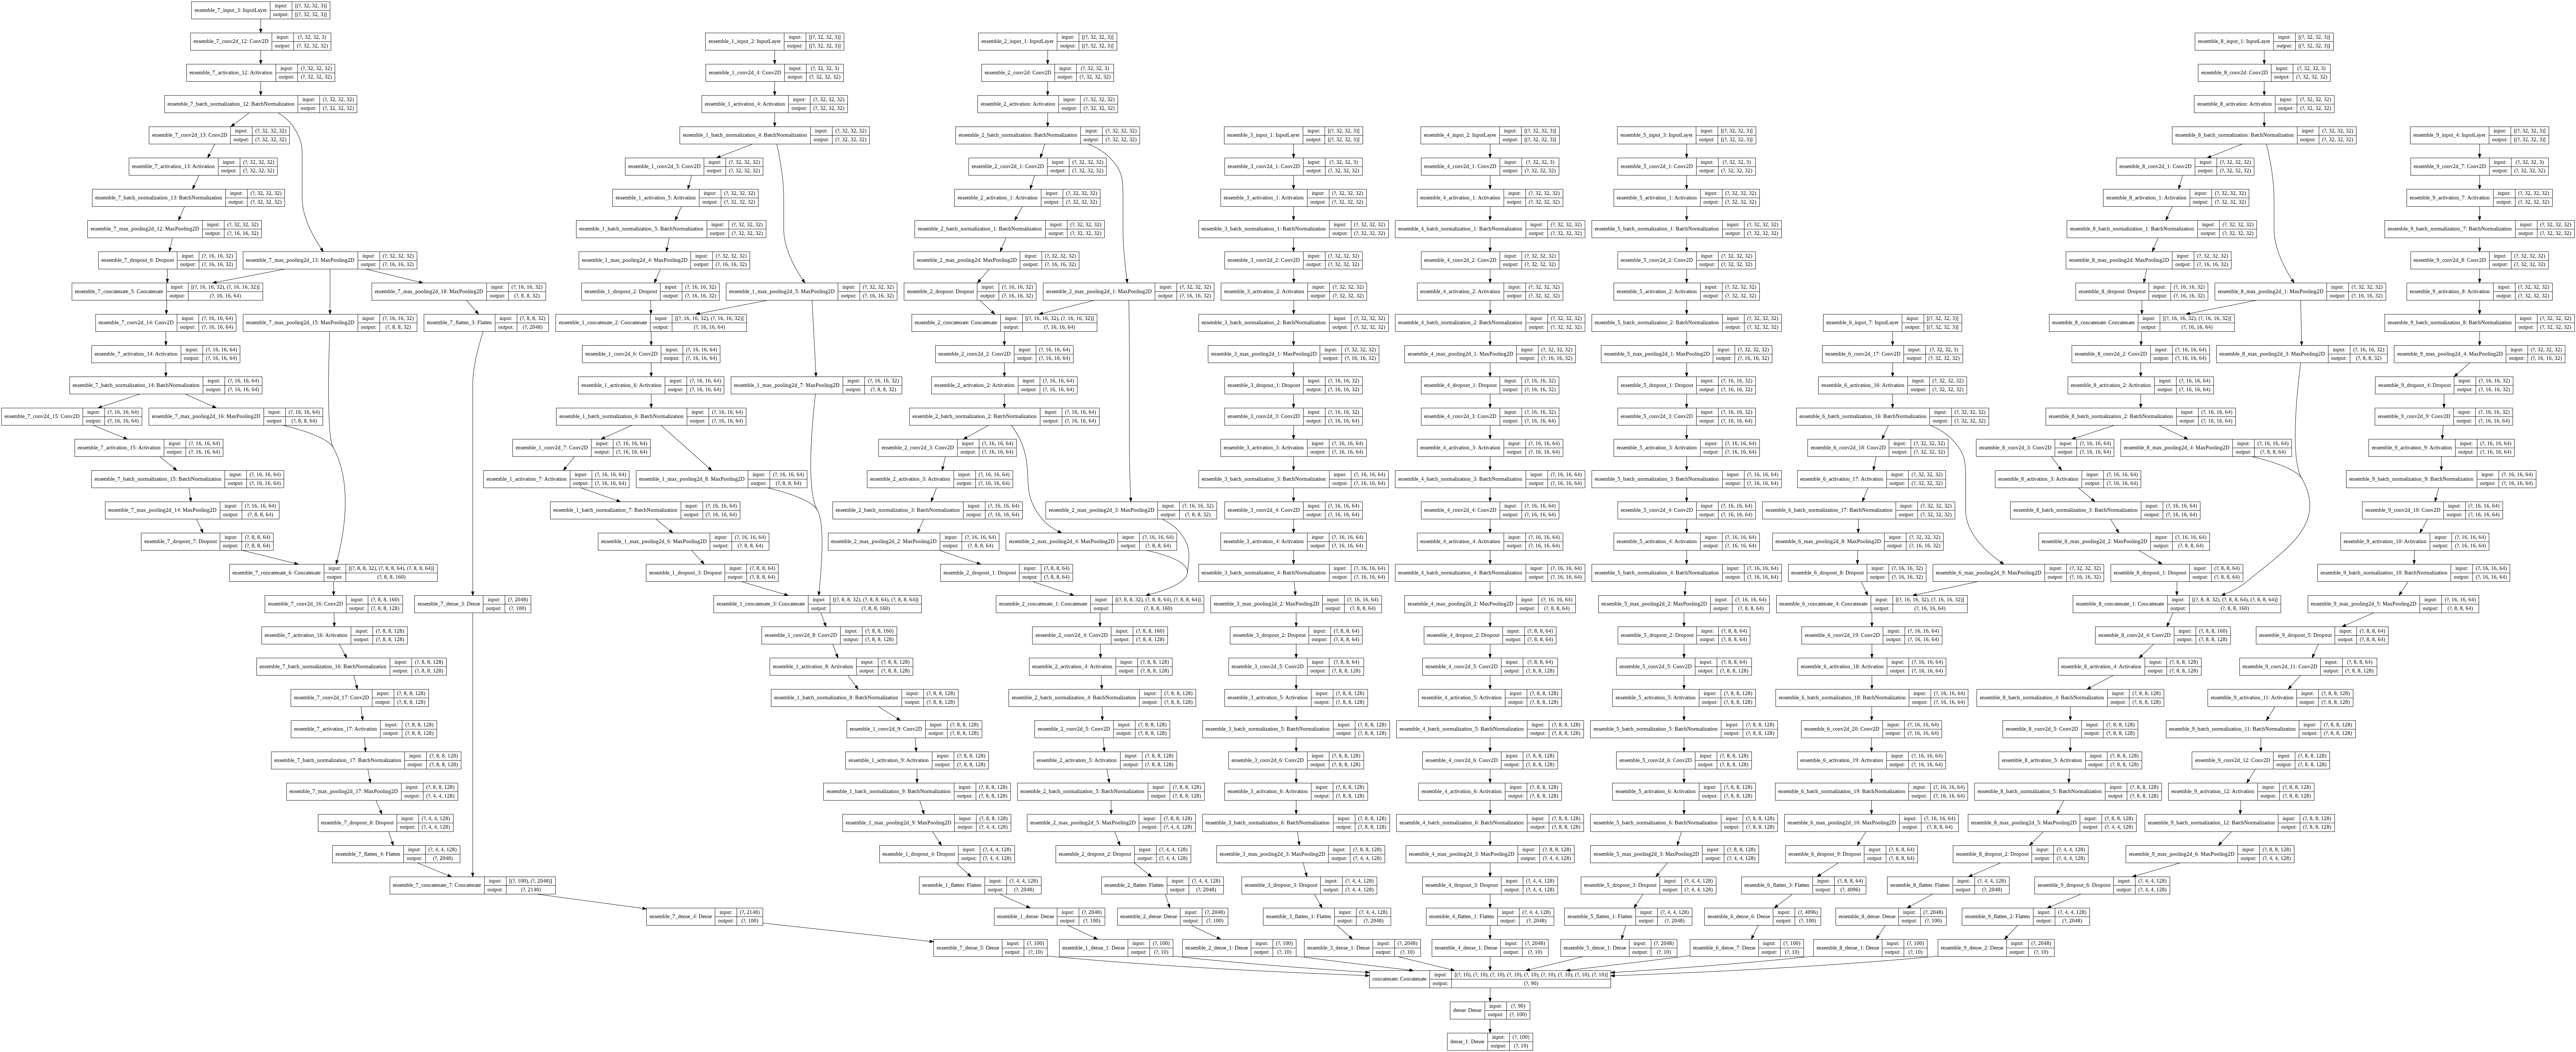

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Data augumentation

In [0]:
datagen_multi = generate_data_generator_for_two_images(x_train, y_train, 64, len(members))

### Callbacks

In [0]:
run_path = "/content/drive/My Drive/Colab Notebooks/mgu/meta_stacked"
mcp_save = keras.callbacks.ModelCheckpoint(os.path.join(run_path, 'model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5'),
                           save_best_only=True, monitor='val_accuracy')
callbacks = [mcp_save]

### Training

In [12]:
batch_size = 64
opt_rms = keras.optimizers.RMSprop(lr=0.00001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model.load_weights("/content/drive/My Drive/Colab Notebooks/mgu/meta_stacked/model-019-0.961363-0.919100.h5")
model.fit(datagen_multi,\
            steps_per_epoch=x_train.shape[0] // batch_size,epochs=20,\
            verbose=1,validation_data=([x_test for _ in range(len(model.input))],y_test), callbacks=callbacks)


Epoch 1/20
781/781 [==============================] - 22s 28ms/step - loss: 1.3312 - accuracy: 0.9596 - val_loss: 1.5195 - val_accuracy: 0.9182
Epoch 2/20
781/781 [==============================] - 20s 26ms/step - loss: 1.3273 - accuracy: 0.9609 - val_loss: 1.5208 - val_accuracy: 0.9182
Epoch 3/20
781/781 [==============================] - 20s 26ms/step - loss: 1.3225 - accuracy: 0.9625 - val_loss: 1.5226 - val_accuracy: 0.9180
Epoch 4/20
781/781 [==============================] - 20s 26ms/step - loss: 1.3287 - accuracy: 0.9621 - val_loss: 1.5237 - val_accuracy: 0.9181
Epoch 5/20
781/781 [==============================] - 20s 26ms/step - loss: 1.3244 - accuracy: 0.9617 - val_loss: 1.5251 - val_accuracy: 0.9184
Epoch 6/20
781/781 [==============================] - 20s 25ms/step - loss: 1.3262 - accuracy: 0.9621 - val_loss: 1.5269 - val_accuracy: 0.9179
Epoch 7/20
781/781 [==============================] - 20s 25ms/step - loss: 1.3217 - accuracy: 0.9645 - val_loss: 1.5285 - val_accuracy:

### Testing fine tuning on x_train not augumented

In [13]:
scores = model.evaluate([x_test for _ in range(len(model.input))], y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

79/79 [==============================] - 2s 30ms/step - loss: 1.5403 - accuracy: 0.9183

Test result: 91.830 loss: 1.540


In [14]:
fit_stacked_model(model, x_train, y_train, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 24s 15ms/step - loss: 1.3142 - accuracy: 0.9672
Epoch 2/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.3083 - accuracy: 0.9690
Epoch 3/10
1563/1563 [==============================] - 24s 15ms/step - loss: 1.3063 - accuracy: 0.9698
Epoch 4/10
1563/1563 [==============================] - 24s 15ms/step - loss: 1.3041 - accuracy: 0.9699
Epoch 5/10
1563/1563 [==============================] - 24s 15ms/step - loss: 1.3024 - accuracy: 0.9702
Epoch 6/10
1563/1563 [==============================] - 24s 15ms/step - loss: 1.3022 - accuracy: 0.9703
Epoch 7/10
1563/1563 [==============================] - 24s 15ms/step - loss: 1.3025 - accuracy: 0.9704
Epoch 8/10
1563/1563 [==============================] - 24s 15ms/step - loss: 1.3023 - accuracy: 0.9700
Epoch 9/10
1563/1563 [==============================] - 24s 15ms/step - loss: 1.3015 - accuracy: 0.9710
Epoch 10/10
1563/1563 [==============================] - 24s 15m

In [15]:
scores = model.evaluate([x_test for _ in range(len(model.input))], y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

79/79 [==============================] - 2s 30ms/step - loss: 1.5251 - accuracy: 0.9229

Test result: 92.290 loss: 1.525
